**Objective**

The objective of the project is to label the pixels of a road in images as either road/not-road by implementing a Fully Convolutional Network for semantic segmentation. This classification will help other systems in the car determine where the free space is. This technique could be extended to more classes like road, vehicle, bicycle and pedestrian.

In this implementation, MobileNet V2 is used as base feature extractor (encoder).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# If running on Google Drive, set gdrive to True
gdrive = True


if (gdrive):
    # Access files on the google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    
    # Path variables to access project relevant files
    root_dir = "/content/gdrive/MyDrive/"
    base_dir = root_dir + 'Colab Notebooks/Semantic_Segmentation/'
    
else:
    base_dir = './'
    
data_dir = base_dir + 'data/'


Mounted at /content/gdrive


**Download Segmentation Dataset**

Download the [Kitti Road](http://www.cvlibs.net/datasets/kitti/eval_road.php) dataset from [here](http://www.cvlibs.net/download.php?file=data_road.zip).

The dataset includes 289 labeled images for training and 290 images for testing purposes.

In [3]:
import os
import sys
import urllib.request
import zipfile
import pathlib
import glob


def download(base_dir, data_dir):
    
  print("Downloading data")

  url = 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip'

  zip_file = 'data_road.zip'

  if (not (os.path.isfile('data_road.zip'))):
    urllib.request.urlretrieve(url, zip_file)
  
  else:
    size = os.path.getsize(zip_file)
    if (size == 470992343):
      print("data_road.zip is already available")
    else:
      os.remove(zip_file)
      urllib.request.urlretrieve(url, zip_file)  

      
  zip_ref = zipfile.ZipFile(zip_file, 'r')
  zip_ref.extractall(data_dir)
  zip_ref.close()


  # Removing files not required for the project
  train_path = data_dir + "/data_road/training/"
  remove_list = glob.iglob(os.path.join(train_path, 'gt_image_2', '*_lane_*.png'))
  
  for filepath in (remove_list):
    print("Deleting: ", filepath)
    try:
      input("Press Enter to continue, Cntrl C to exit ...")
      os.remove(filepath)
    except:
      print("Interrupted while deleting the file: ", filepath)
      sys.exit()
      
  print("Files extracted")

    

def getData(base_dir, data_dir):

  if (os.path.isdir(data_dir + "/data_road/training/")): 
    print('Data already exists')
  else:
    download(base_dir, data_dir)
  

  print("Training Set Count: ", len(next(os.walk(data_dir + "/data_road/training/image_2/"))[2]))
  print("Mask Set Count: ", len(next(os.walk(data_dir + "/data_road/training/gt_image_2/"))[2]))
  print("Test Set Count: ", len(next(os.walk(data_dir + "/data_road/testing/image_2/"))[2]))
  
  
getData(base_dir, data_dir)



Data already exists
Training Set Count:  289
Mask Set Count:  289
Test Set Count:  290


**Explore Data**

Training images / masks are visualized to get understand data.

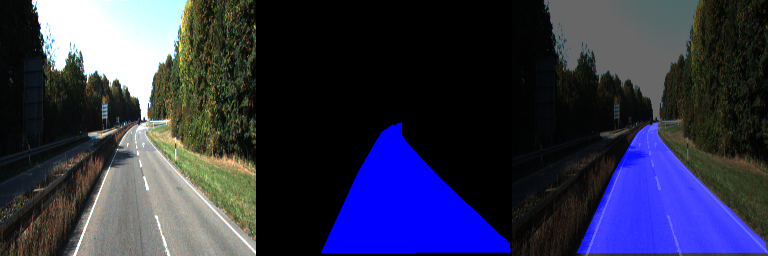

In [4]:
import cv2
from google.colab.patches import cv2_imshow

image_number = '091'
imgpath = data_dir + 'data_road/training/image_2/umm_000' + image_number + '.png'
maskpath = data_dir + 'data_road/training/gt_image_2/umm_road_000' + image_number + '.png'

img = cv2.imread(imgpath)
mask = cv2.imread(maskpath)

b, g, r = cv2.split(mask)
mask = cv2.merge((b, g, g))   # convert red to blue

img = cv2.resize(img, (256, 256))
mask = cv2.resize(mask, (256, 256))

overlay = cv2.addWeighted(img, 0.4, mask, 1.0, 0.)

concat = (np.concatenate([img, mask, overlay], axis=1))
cv2_imshow(concat)


**Load Data**

Not all training images are loaded to RAM at once. This is done to conserve resources. Images are loaded in batches as and when required.

In [5]:
# https://stackoverflow.com/questions/70367583/how-does-the-keras-method-image-dataset-from-directory-distinguish-x-and-y-dat

import glob
X = sorted(glob.glob(data_dir + 'data_road/training/image_2/*.png'))
y = sorted(glob.glob(data_dir + 'data_road/training/gt_image_2/*.png'))


X_test = glob.glob(data_dir + 'data_road/testing/image_2/*.png')

df = pd.DataFrame()
df['X'] = X
df['y'] = y



In [6]:
def read_images(img_path, segmentation_mask_path):
    img_data = tf.io.read_file(img_path)
    img = tf.io.decode_png(img_data)
    
    segm_data = tf.io.read_file(segmentation_mask_path)
    # Sparse Categorical Cross Entropy - channels = 1
    # Categorical Cross Entropy / IOU - channels = 3
    segm_mask = tf.io.decode_png(segm_data, channels=3)
    
    return img, segm_mask


def data_loader(train_index, val_index):

    #Split the data into train and validation sets.
    training_split = df.iloc[train_index]
    validation_split = df.iloc[val_index]

    X_train = training_split['X']
    y_train = training_split['y']

    X_val = validation_split['X']
    y_val = validation_split['y']

    # Below variables refer to image/mask file paths and not actual image/mask
    X_train = tf.data.Dataset.from_tensor_slices(X_train)
    y_train = tf.data.Dataset.from_tensor_slices(y_train)
    X_val = tf.data.Dataset.from_tensor_slices(X_val)
    y_val = tf.data.Dataset.from_tensor_slices(y_val)

    # Zip input images and ground truth masks. 
    train = tf.data.Dataset.zip((X_train, y_train))
    val = tf.data.Dataset.zip((X_val, y_val)) 

    # Load images / masks using file path
    train = train.map(read_images)
    val = val.map(read_images)

    return train, val



**Data Preprocessing**

In [7]:
HEIGHT = 256
WIDTH = 256

def resize_images(img, mask):
    img = tf.image.resize(img, (HEIGHT, WIDTH))
    mask = tf.image.resize(mask, (HEIGHT, WIDTH))
    
    return img, mask


def normalize_images(img, mask):

    img = tf.cast(img, tf.float32) / 255.0

    #mask = tf.cast(mask, tf.float32) / 105.0      # Sparse Categorical Cross Entropy
    mask = tf.cast(mask, tf.float32) / 255.0     # IOU
    
    return img, mask


def data_preprocess(ds):

    ds = ds.map(resize_images)
    ds = ds.map(normalize_images)

    return ds



**Model Selection: U-Net Model**

The functional approach of U-Net architecture is used, but we will have our own architecture suitable to our task. The downstack can be a pre-trained CNN, trained for image classification (e.g. MobileNetV2, ResNet, NASNet, Inception, DenseNet, or EfficientNet). It can effectively extract the features. But, we have to build our upstack to match our classes (here, 3), build skip-connections, and train it with our data. 

We prefer a pre-trained MobileNetV2 to be the downstack that can be obtained through transfer learning and build the upstack with pix2pix, a publicly available generative upstack template

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[HEIGHT, WIDTH, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 128x128    64x64
    'block_3_expand_relu',   # 64x64      32x32
    'block_6_expand_relu',   # 32x32      16x16
    'block_13_expand_relu',  # 16x16      8x8
    'block_16_project',      # 8x8        4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [9]:
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(1024, 3),  # 4x4 -> 8x8
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),   # 32x32 -> 64x64
]


**Integrate the Segmentation Model**

Build a U-Net model by merging downstack and upstack with skip-connections.

In [10]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[HEIGHT, WIDTH, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [11]:
OUTPUT_CLASSES = 3
model = unet_model(output_channels=OUTPUT_CLASSES)


**Data Augmentation**

Since we have limited images, we prepare more data through augmentation.

There are only 289 train examples. That’s too low for training. We define a couple of augmentation functions to generate more train examples.

In [12]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (HEIGHT, WIDTH))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (HEIGHT, WIDTH))
    #mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask


def data_augment(train):
    # perform augmentation on train data only
    a = train.map(brightness)
    b = train.map(gamma)
    c = train.map(hue)
    d = train.map(crop)
    e = train.map(flip_hori)
    f = train.map(flip_vert)
    g = train.map(rotate)

    train = train.concatenate(a)
    train = train.concatenate(b)
    train = train.concatenate(c)
    train = train.concatenate(d)
    train = train.concatenate(e)
    train = train.concatenate(f)
    train = train.concatenate(g) 

    return train



**Load the model**

Model weights of a good run are saved periodically and are loaded at later time. This saves us from training the model all over again.

In [8]:
model = tf.keras.models.load_model(base_dir + '/mar30.h5')


### Trial 0: Sparse Categorical Crossentropy

Resolving Loss = NaN issue

1. segm_mask = tf.io.decode_png(segm_data, channels=1)

2. Changing mask dtype to tf.uint8 does not help

3. Rescaling masks helps to avoid NaN error


**Choice of K_Fold cross validation**

KFold slows down the training process. Given that number of training samples available is too limited, chose this method to train the model.


In [ ]:
tf.random.set_seed(10)

from sklearn.model_selection import KFold
kf = KFold(n_splits = 9, random_state = 7, shuffle = True)

# Prepare data batches and shuffle the train data
EPOCHS = 1
BATCH = 16
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 257/BATCH
VALIDATION_STEPS = 32/BATCH


model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

k = 0
for train_index, val_index in kf.split(X, y):
    
    train, val = data_loader(train_index, val_index)
    
    train = data_preprocess(train)
    val = data_preprocess(val)

    train = data_augment(train)

    train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
    train = train.prefetch(buffer_size=AT)

    val = val.batch(BATCH) 

    model_history = model.fit(train,
                validation_data=val,
                steps_per_epoch=STEPS_PER_EPOCH,
                validation_steps=VALIDATION_STEPS,
                epochs=EPOCHS)
    
    k += 1
    print("Folds completed: ", k)


16/16 [==============================] - 33s 665ms/step - loss: 0.0490 - accuracy: 0.1752 - val_loss: 0.0433 - val_accuracy: 0.1712
Folds completed:  1
16/16 [==============================] - 28s 597ms/step - loss: 0.0450 - accuracy: 0.1756 - val_loss: 0.0438 - val_accuracy: 0.1758
Folds completed:  2
16/16 [==============================] - 28s 596ms/step - loss: 0.0427 - accuracy: 0.1769 - val_loss: 0.0405 - val_accuracy: 0.1830
Folds completed:  3
16/16 [==============================] - 28s 597ms/step - loss: 0.0448 - accuracy: 0.1809 - val_loss: 0.0363 - val_accuracy: 0.1693
Folds completed:  4
16/16 [==============================] - 28s 597ms/step - loss: 0.0430 - accuracy: 0.1741 - val_loss: 0.0329 - val_accuracy: 0.1908
Folds completed:  5
16/16 [==============================] - 28s 590ms/step - loss: 0.0396 - accuracy: 0.1816 - val_loss: 0.0317 - val_accuracy: 0.1830
Folds completed:  6
16/16 [==============================] - 28s 598ms/step - loss: 0.0381 - accuracy: 0.183

**Visualize training samples**

In [ ]:
def display(display_list, size):
  plt.figure(figsize=(size, size))

  title = ['Input Image', 'Predicted Mask', 'True Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)], 15)
  else:
    random_list = np.random.randint(0, 289, 5)
    for i in random_list:
      imgpath = X_test[i]
      sample_image = cv2.imread(imgpath)
      sample_image = tf.image.resize(sample_image, (HEIGHT, WIDTH))
      sample_image = tf.cast(sample_image, tf.float32) / 255.0
      display([sample_image, create_mask(model.predict(sample_image[tf.newaxis, ...]))],10)



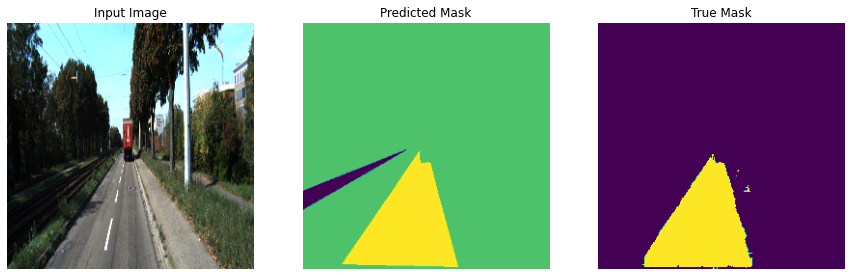

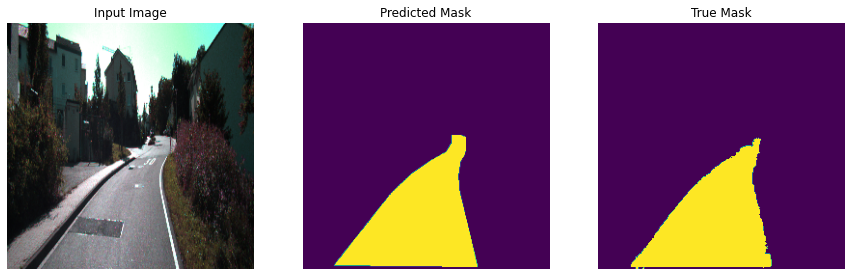

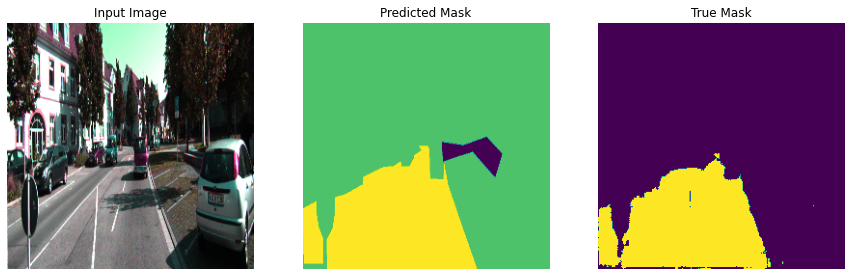

In [ ]:
show_predictions(train, 3)
# show_predictions()


**Check model generalization capability**

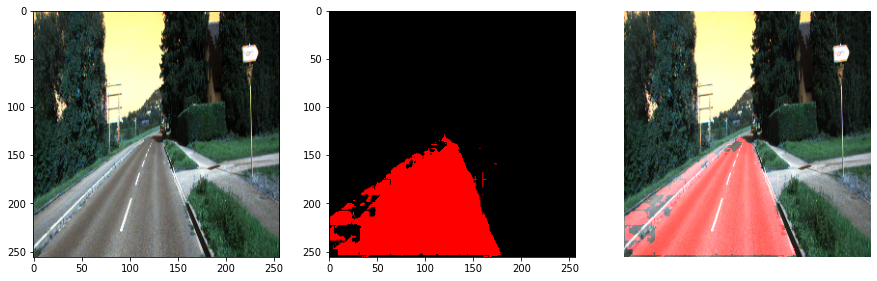

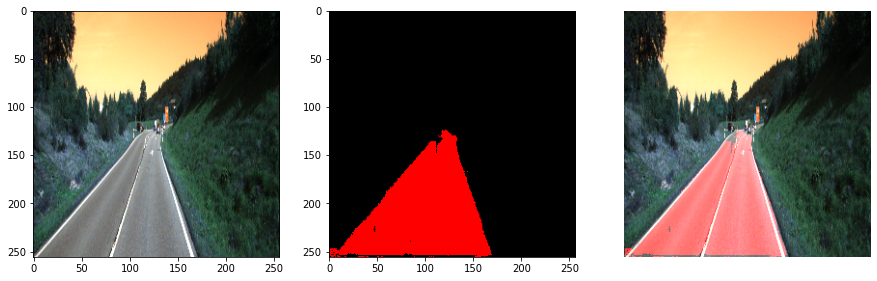

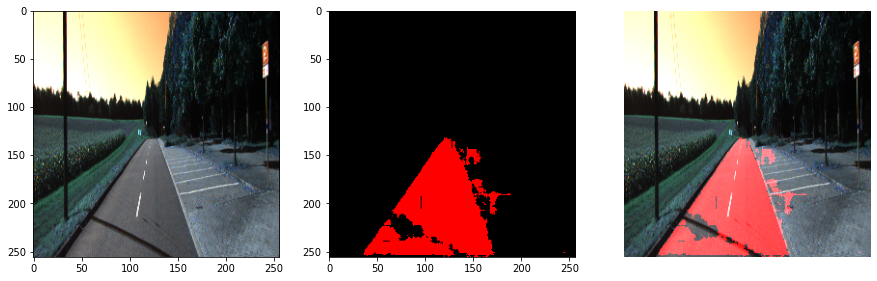

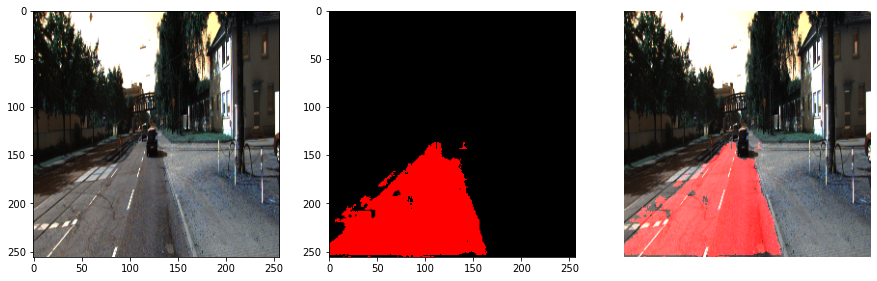

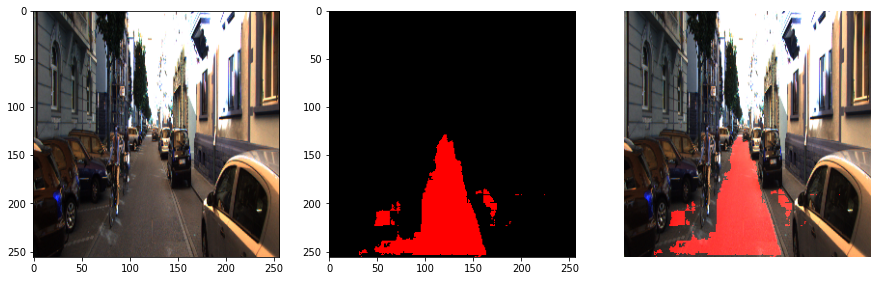

In [ ]:
#from PIL import Image

# Predicting images from the test set
def predict_images():

    random_list = np.random.randint(0, 289, 5)
    
    for i in random_list:
      imgpath = X_test[i]
      img_arr = cv2.imread(imgpath)
      
      img_org = cv2.imread(imgpath)
      img_org = cv2.resize(img_org, (HEIGHT, WIDTH))

      #img_org = Image.open(imgpath)                                        #PIL
      #img_org = img_org.resize([HEIGHT, WIDTH])                            #PIL

      img_arr = tf.image.resize(img_arr, (HEIGHT, WIDTH))
      img_arr = tf.cast(img_arr, tf.float32) / 255.0
      arr_pred = model.predict(img_arr[tf.newaxis, ...])

      arr_pred = tf.argmax(arr_pred, axis=-1)
      arr_pred = arr_pred[..., tf.newaxis]
      pred_mask = tf.keras.utils.array_to_img(arr_pred[0])
      #pred_mask = pred_mask.resize(img_org.size)                           #PIL
      pred_mask = cv2.cvtColor(np.array(pred_mask), cv2.COLOR_BGR2RGB)

      #b, g, r = cv2.split(pred_mask)
      #pred_mask = cv2.merge((b, b, b))   # convert red to blue
      pred_mask[np.where((pred_mask==[255, 255, 255]).all(axis=2))] = [255, 0, 0]

      img_overlay = cv2.addWeighted(img_org, 1.0, pred_mask, 1.0, 0.)
      #img_org.paste(pred_mask, (0,0), mask=pred_mask)                      #PIL

      plt.figure(figsize=(15, 15))

      plt.subplot(1, 3, 1)
      img_arr = tf.keras.utils.array_to_img(img_arr)
      plt.imshow(img_arr)

      plt.subplot(1, 3, 2)
      plt.imshow(pred_mask)

      plt.subplot(1, 3, 3)
      plt.imshow(img_overlay)
      plt.axis('off')


predict_images()



**Save a good run**

In [ ]:
model.save(base_dir + '/mar30.h5')


**Function to accept images from a video file**

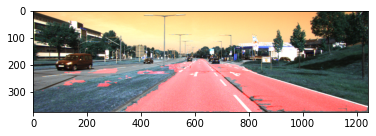

In [22]:
def process_video(img_org):

      img_arr = img_org.copy()
      org_height, org_width, _ = img_arr.shape

      img_arr = tf.image.resize(img_arr, (HEIGHT, WIDTH))
      img_arr = tf.cast(img_arr, tf.float32) / 255.0
      
      # Equivalent to tf.expand_dims
      arr_pred = model.predict(img_arr[tf.newaxis, ...])

      arr_pred = tf.argmax(arr_pred, axis=-1)
      arr_pred = arr_pred[..., tf.newaxis]
      pred_mask = tf.keras.utils.array_to_img(arr_pred[0])

      pred_mask = cv2.cvtColor(np.array(pred_mask), cv2.COLOR_BGR2RGB)

      pred_mask[np.where((pred_mask==[255, 255, 255]).all(axis=2))] = [255, 0, 0]

      pred_mask = cv2.resize(pred_mask, (org_width, org_height))

      img_overlay = cv2.addWeighted(img_org, 1.0, pred_mask, 1.0, 0.)

      return img_overlay


random_list = np.random.randint(0, 289, 5)
img = cv2.imread(X_test[random_list[0]])

plt.imshow(process_video(img))


In [23]:
from moviepy.editor import VideoFileClip

video_path = base_dir + 'project_video.mp4'
out_path = base_dir + 'project_out_mar30.mp4'

#white_output = 'project_out.mp4'

clip1 = VideoFileClip(video_path)
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
white_clip.write_videofile(out_path, audio=False)


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2908160/45929032 bytes (6.3%)5824512/45929032 bytes (12.7%)8986624/45929032 bytes (19.6%)12058624/45929032 bytes (26.3%)15089664/45929032 bytes (32.9%)18079744/45929032 bytes (39.4%)20865024/45929032 bytes (45.4%)23740416/45929032 bytes (51.7%)26935296/45929032 bytes (58.6%)29827072/45929032 bytes (64.9%)33038336/45929032 bytes (71.9%)36110336/45929032 bytes (78.6%)

100%|█████████▉| 1260/1261 [08:50<00:00,  2.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/Colab Notebooks/Semantic_Segmentation/project_out_mar30.mp4 



### Trial 1: Categorical Crossentropy

In [13]:
tf.random.set_seed(10)

from sklearn.model_selection import KFold
kf = KFold(n_splits = 9, random_state = 7, shuffle = True)

# Prepare data batches and shuffle the train data
EPOCHS = 2
BATCH = 16
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 257/BATCH
VALIDATION_STEPS = 32/BATCH


model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

k = 0
for train_index, val_index in kf.split(X, y):
    
    train, val = data_loader(train_index, val_index)
    
    train = data_preprocess(train)
    val = data_preprocess(val)

    train = data_augment(train)

    train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
    train = train.prefetch(buffer_size=AT)

    val = val.batch(BATCH) 

    model_history = model.fit(train,
                validation_data=val,
                steps_per_epoch=STEPS_PER_EPOCH,
                validation_steps=VALIDATION_STEPS,
                epochs=EPOCHS)
    
    k += 1
    print("Folds completed: ", k)


Epoch 1/2
16/16 [==============================] - 300s 15s/step - loss: 177.0050 - accuracy: 0.7385 - val_loss: 654.7179 - val_accuracy: 0.5887
Epoch 2/2
16/16 [==============================] - 233s 15s/step - loss: 172.3460 - accuracy: 0.7356 - val_loss: 1131.3418 - val_accuracy: 0.6031
Folds completed:  1
Epoch 1/2
16/16 [==============================] - 261s 15s/step - loss: 193.2676 - accuracy: 0.7119 - val_loss: 613.1772 - val_accuracy: 0.7113
Epoch 2/2
16/16 [==============================] - 248s 16s/step - loss: 225.8305 - accuracy: 0.6932 - val_loss: 531.5974 - val_accuracy: 0.6820
Folds completed:  2
Epoch 1/2
16/16 [==============================] - 259s 15s/step - loss: 251.3490 - accuracy: 0.6925 - val_loss: 335.7409 - val_accuracy: 0.7111
Epoch 2/2
16/16 [==============================] - 255s 16s/step - loss: 272.7987 - accuracy: 0.6895 - val_loss: 321.4998 - val_accuracy: 0.6988
Folds completed:  3
Epoch 1/2
16/16 [==============================] - 249s 14s/step - lo

**Visualize training samples**

In [15]:
def display(display_list, size):
  plt.figure(figsize=(size, size))

  title = ['Input Image', 'Predicted Mask', 'True Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)], 15)
  else:
    random_list = np.random.randint(0, 250, 5)
    for i in random_list:
      imgpath = X_test[i]
      sample_image = cv2.imread(imgpath)
      sample_image = tf.image.resize(sample_image, (HEIGHT, WIDTH))
      sample_image = tf.cast(sample_image, tf.float32) / 255.0
      display([sample_image, create_mask(model.predict(sample_image[tf.newaxis, ...]))],10)



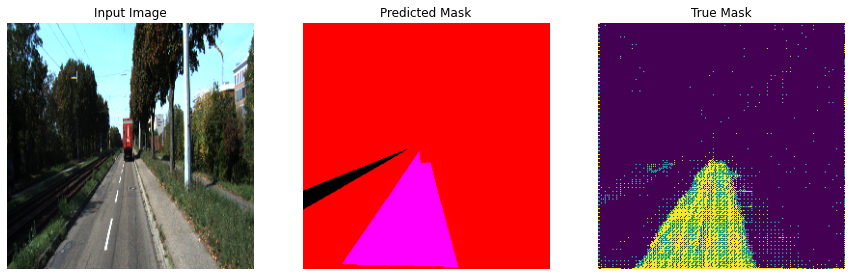

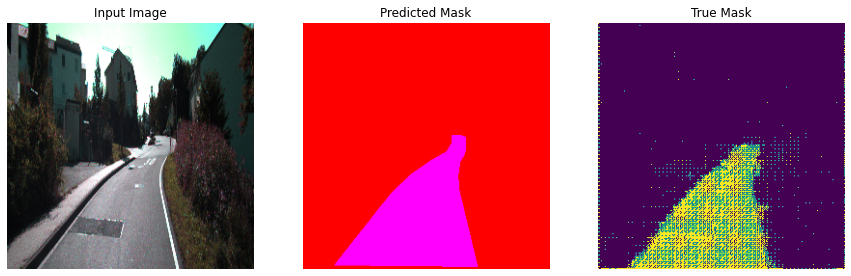

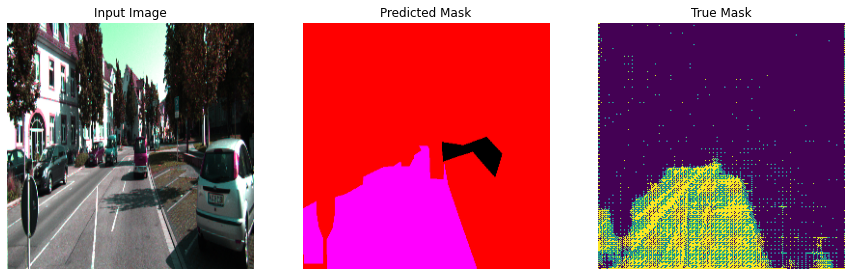

In [16]:
show_predictions(train, 3)


**Output for Test images**

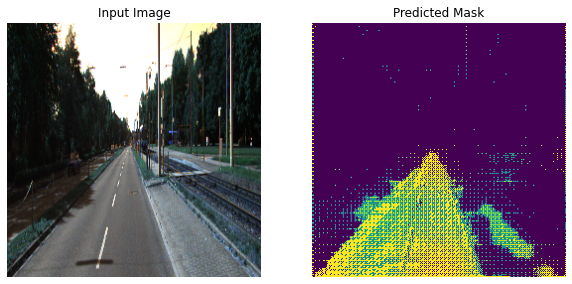

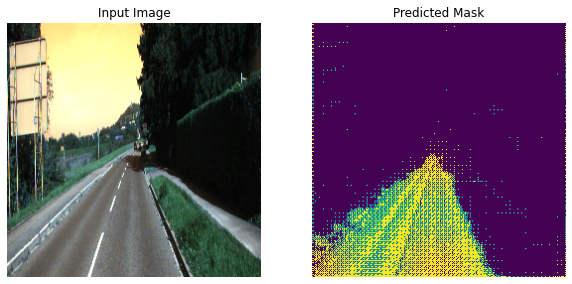

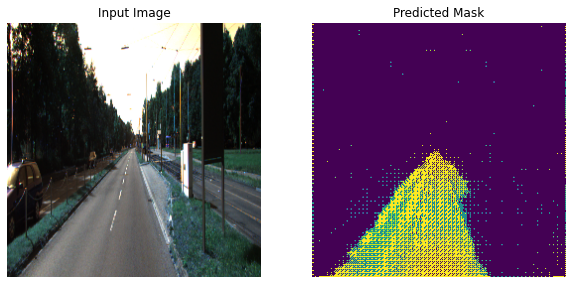

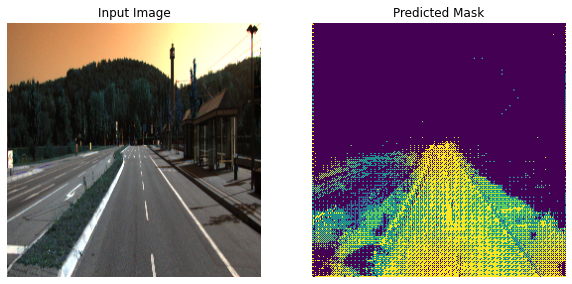

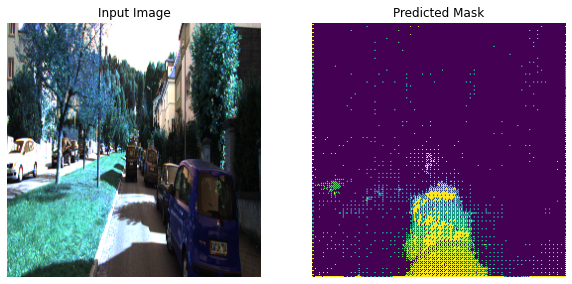

In [17]:
show_predictions()


**Function to accept images from a video**

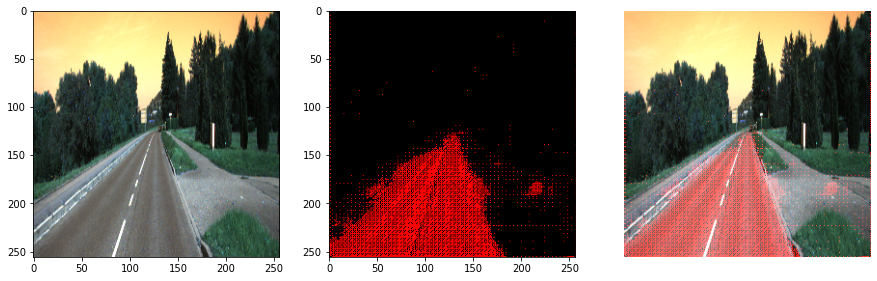

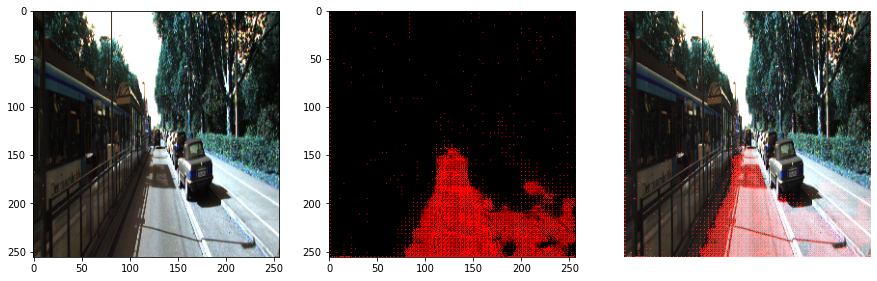

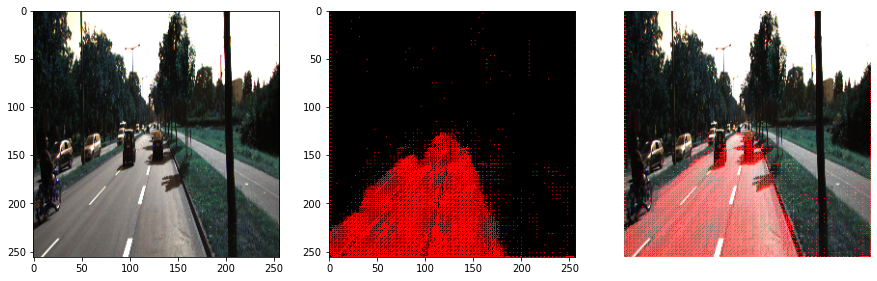

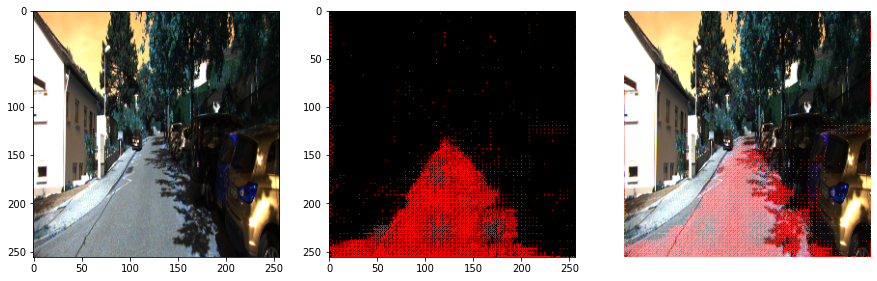

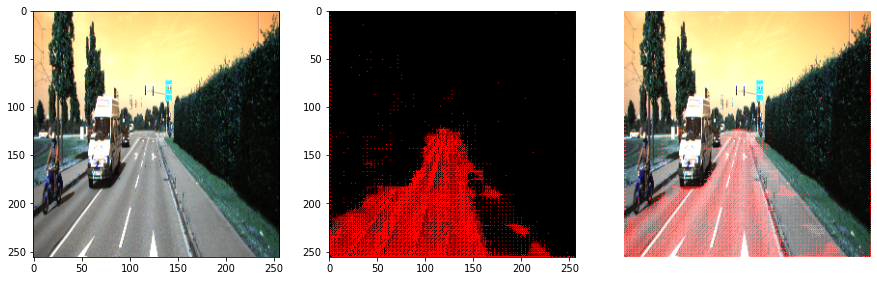

In [18]:
# Predicting images from the test set
def predict_images():

    random_list = np.random.randint(0, 289, 5)
    
    for i in random_list:
      imgpath = X_test[i]
      img_arr = cv2.imread(imgpath)
      
      img_org = cv2.imread(imgpath)
      img_org = cv2.resize(img_org, (HEIGHT, WIDTH))

      #img_org = Image.open(imgpath)                                        #PIL
      #img_org = img_org.resize([HEIGHT, WIDTH])                            #PIL

      img_arr = tf.image.resize(img_arr, (HEIGHT, WIDTH))
      img_arr = tf.cast(img_arr, tf.float32) / 255.0
      arr_pred = model.predict(img_arr[tf.newaxis, ...])

      arr_pred = tf.argmax(arr_pred, axis=-1)
      arr_pred = arr_pred[..., tf.newaxis]
      pred_mask = tf.keras.utils.array_to_img(arr_pred[0])
      #pred_mask = pred_mask.resize(img_org.size)                           #PIL
      pred_mask = cv2.cvtColor(np.array(pred_mask), cv2.COLOR_BGR2RGB)

      #b, g, r = cv2.split(pred_mask)
      #pred_mask = cv2.merge((b, b, b))   # convert red to blue
      pred_mask[np.where((pred_mask==[255, 255, 255]).all(axis=2))] = [255, 0, 0]

      img_overlay = cv2.addWeighted(img_org, 1.0, pred_mask, 1.0, 0.)
      #img_org.paste(pred_mask, (0,0), mask=pred_mask)                      #PIL

      plt.figure(figsize=(15, 15))

      plt.subplot(1, 3, 1)
      img_arr = tf.keras.utils.array_to_img(img_arr)
      plt.imshow(img_arr)

      plt.subplot(1, 3, 2)
      plt.imshow(pred_mask)

      plt.subplot(1, 3, 3)
      plt.imshow(img_overlay)
      plt.axis('off')


predict_images()


In [19]:
model.save(base_dir + '/mar30_cat_entropy.h5')


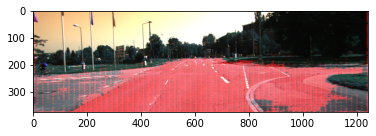

In [23]:
def process_video(img_org):

      img_arr = img_org.copy()
      org_height, org_width, _ = img_arr.shape

      img_arr = tf.image.resize(img_arr, (HEIGHT, WIDTH))
      img_arr = tf.cast(img_arr, tf.float32) / 255.0
      
      # Equivalent to tf.expand_dims
      arr_pred = model.predict(img_arr[tf.newaxis, ...])

      arr_pred = tf.argmax(arr_pred, axis=-1)
      arr_pred = arr_pred[..., tf.newaxis]
      pred_mask = tf.keras.utils.array_to_img(arr_pred[0])

      pred_mask = cv2.cvtColor(np.array(pred_mask), cv2.COLOR_BGR2RGB)

      pred_mask[np.where((pred_mask==[255, 255, 255]).all(axis=2))] = [255, 0, 0]

      pred_mask = cv2.resize(pred_mask, (org_width, org_height))

      img_overlay = cv2.addWeighted(img_org, 1.0, pred_mask, 1.0, 0.)

      return img_overlay


random_list = np.random.randint(0, 289, 5)
img = cv2.imread(X_test[random_list[0]])

plt.imshow(process_video(img))


In [24]:
from moviepy.editor import VideoFileClip

video_path = base_dir + 'project_video.mp4'
out_path = base_dir + 'project_out_mar30_cat_entropy.mp4'

#white_output = 'project_out.mp4'

clip1 = VideoFileClip(video_path)
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
white_clip.write_videofile(out_path, audio=False)


[MoviePy] >>>> Building video /content/gdrive/MyDrive/Colab Notebooks/Semantic_Segmentation/project_out_mar30_cat_entropy.mp4
[MoviePy] Writing video /content/gdrive/MyDrive/Colab Notebooks/Semantic_Segmentation/project_out_mar30_cat_entropy.mp4


100%|█████████▉| 1260/1261 [10:37<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/Colab Notebooks/Semantic_Segmentation/project_out_mar30_cat_entropy.mp4 



## References


https://www.tensorflow.org/tutorials/images/segmentation

https://analyticsindiamag.com/semantic-segmentation-using-tensorflow-keras/

https://www.youtube.com/playlist?list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE

